In [67]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)

# for CVXPY implementation
from solardatatools.signal_decompositions import tl1_l2d2p365 as cvx_sd

# for OSD implementation
from solardatatools.osd_signal_decompositions import tl1_l2d2p365 as osd_sd

# Import data from `tests/fixtures`

In [2]:
# Import data
fixtures_path = "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/"

data_file_path = Path(fixtures_path + "clear_day_detection/one_year_power_signals_1.csv")

with open(data_file_path) as file:
    data = np.loadtxt(file, delimiter=",")
expected_data_file_path = Path(fixtures_path + "clear_day_detection/one_year_weights_1.csv")

with open(expected_data_file_path) as file:
    expected_output = np.loadtxt(file, delimiter=",")

## Preprocess data to obtain metric

In [3]:
daily_sparsity = np.sum(data > 0.005 * np.max(data), axis=0)

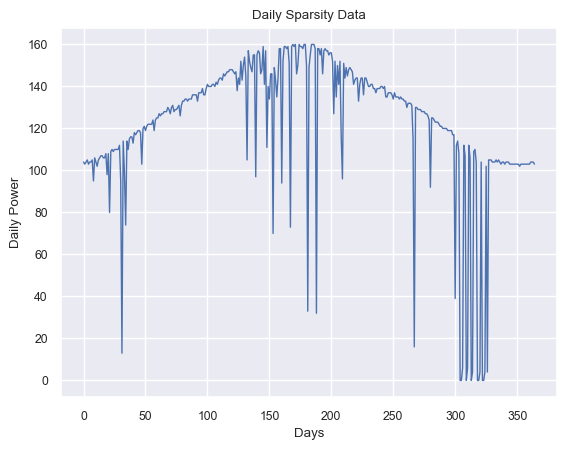

In [23]:
plt.plot(daily_sparsity, linewidth=1);
plt.ylabel("Daily Power")
plt.xlabel("Days")
plt.title("Daily Sparsity Data")
plt.savefig("daily_sparsity_data", dpi=300)

# Run tests

## Compare CVXPY/OSD with identical weights

### With MOSEK/QSS

CVXPY objective       3303.95276
OSD objective, scaled 3303.96709
MAE (OSD,CVX)   2.30e-04


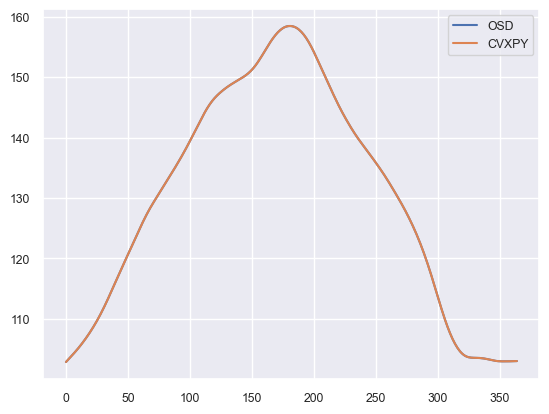

In [5]:
cvx_t1 = cvx_sd(daily_sparsity, c1=1e3, yearly_periodic=False, solver="MOSEK")
osd_t1 = osd_sd(daily_sparsity, w2=1e3, yearly_periodic=False, solver="QSS")

# get scaled obj from cvxpy
cvx_sd(daily_sparsity, c1=1e3, yearly_periodic=False, solver="MOSEK", comp_osd=osd_t1)
print(f'MAE (OSD,CVX)   {mae(cvx_t1, osd_t1):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(osd_t1, label="OSD")
ax1.plot(cvx_t1, label="CVXPY")
ax1.legend()
plt.show()

### With MOSEK/MOSEK

CVXPY objective       379.74788
OSD objective, scaled 379.74788
MAE (OSD+MOSEK,CVX)   3.38e-11
MAE (OSD+QSS,CVX)     2.49e-04


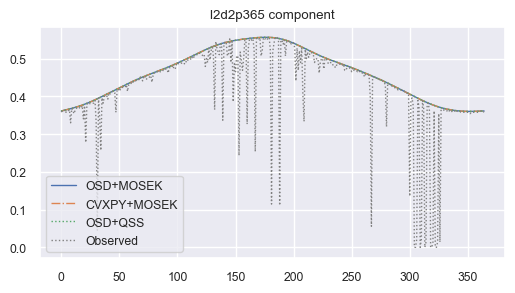

In [76]:
w = 8e2
cvx_t1 = cvx_sd(daily_sparsity, tau=0.9, c1=w, yearly_periodic=False, solver="MOSEK")
osd_t1 = osd_sd(daily_sparsity, tau=0.9, w2=w, yearly_periodic=False, solver="MOSEK")
osd_qss_t1 = osd_sd(daily_sparsity, tau=0.9, w2=w, yearly_periodic=False, solver="QSS")

# get scaled obj from cvxpy
cvx_sd(daily_sparsity, tau=0.9, c1=w, yearly_periodic=False, solver="MOSEK", comp_osd=osd_t1)
print(f'MAE (OSD+MOSEK,CVX)   {mae(cvx_t1, osd_t1):.2e}')
print(f'MAE (OSD+QSS,CVX)     {mae(cvx_t1, osd_qss_t1):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True, figsize=(6,3))
ax1.plot(osd_t1/288, label="OSD+MOSEK", linewidth=1)
ax1.plot(cvx_t1/288, label="CVXPY+MOSEK", linewidth=1, linestyle="-.")
ax1.plot(osd_qss_t1/288, label="OSD+QSS", linewidth=1, linestyle=":")
ax1.plot(daily_sparsity/288,  label="Observed", linewidth=1, linestyle=":", color="gray");

ax1.set_title("l2d2p365 component")
#ax1.plot(daily_sparsity, linestyle=":", alpha=0.7)
ax1.legend()
plt.savefig("daily_sparsity_l2d2p365_real", dpi=300)

## Compare CVXPY/OSD

CVXPY objective       3303.95276
OSD objective, scaled 122507.39190
MAE (OSD,CVX)   8.72e-04


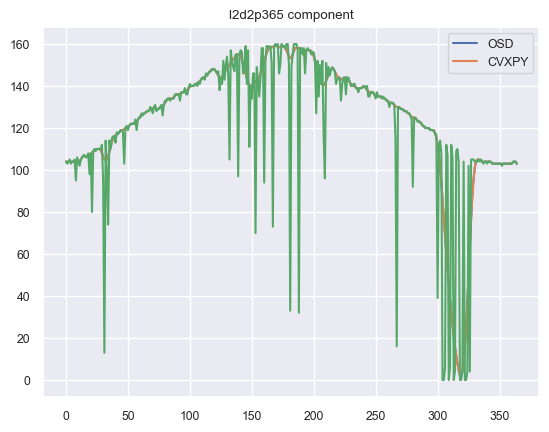

In [15]:
cvx_t1 = cvx_sd(daily_sparsity, c1=1e3*.001, yearly_periodic=False, solver="MOSEK")
osd_t1 = osd_sd(daily_sparsity, w2=1e3*.001, yearly_periodic=False, solver="QSS")

# get scaled obj from cvxpy
cvx_sd(daily_sparsity, c1=1e3, yearly_periodic=False, solver="MOSEK", comp_osd=osd_t1)
print(f'MAE (OSD,CVX)   {mae(cvx_t1, osd_t1):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(osd_t1, label="OSD")
ax1.plot(cvx_t1, label="CVXPY")
ax1.plot(daily_sparsity);
ax1.set_title("l2d2p365 component")
ax1.legend()
plt.show()

## Doubling length to make it 2 years

In [8]:
data_long = np.array(list(daily_sparsity) + list(daily_sparsity))

CVXPY objective       6610.07146
OSD objective, scaled 6610.09077
MAE (OSD,CVX)   2.35e-04


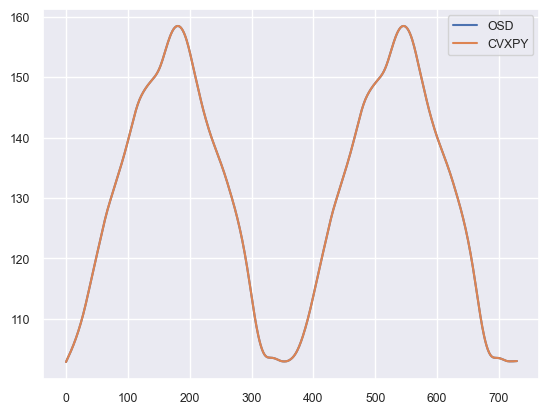

In [9]:
cvx_t2 = cvx_sd(data_long, c1=1e3, yearly_periodic=False, solver="MOSEK")
osd_t2 = osd_sd(data_long, w2=1e3, yearly_periodic=False, solver="QSS")

# get scaled obj from cvxpy
cvx_sd(data_long, c1=1e3, yearly_periodic=False, solver="MOSEK", comp_osd=osd_t2)
print(f'MAE (OSD,CVX)   {mae(cvx_t2, osd_t2):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(osd_t2, label="OSD")
ax1.plot(cvx_t2, label="CVXPY")
ax1.legend()
plt.show()

### Adding periodicity

CVXPY objective       6611.91428
OSD objective, scaled 6611.91453
MAE (OSD,CVX)   1.58e-04


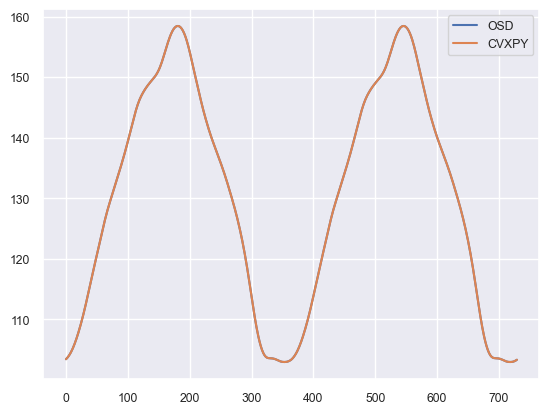

In [10]:
cvx_t2 = cvx_sd(data_long, c1=1e3, yearly_periodic=True, solver="MOSEK")
osd_t2 = osd_sd(data_long, w2=1e3, yearly_periodic=True, solver="QSS")

# get scaled obj from cvxpy
cvx_sd(data_long, c1=1e3, yearly_periodic=True, solver="MOSEK", comp_osd=osd_t2)
print(f'MAE (OSD,CVX)   {mae(cvx_t2, osd_t2):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(osd_t2, label="OSD")
ax1.plot(cvx_t2, label="CVXPY")
ax1.legend()
plt.show()